In [1]:
!python --version

Python 3.6.12 :: Anaconda, Inc.


# Imports

In [2]:
import pandas as pd
import numpy as np
import os
import time
import tensorflow as tf
import tensorflow_hub as hub
import zipfile
from html2text import HTML2Text
from tqdm import tqdm
import re
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns

# Set pandas print options

This will improve readability of printed pandas dataframe.


In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Set global Parameters

Set your parameters here:

data_path: In this path put the data you have downloaded with YouTube Data Tools. output_path: Tghe files generated in this notebook will be saved here.

url_dict: URLs to models on Tensorflow hub are saved here. Other models are available there. model_type: Define which model you would like to use. Choose one from url_dict

new_embeddings: If this is true, new embeddings will be generated and saved at output_path. Otherwise, embeddings are loaded from Disc.

In [4]:
data_path = './data/comments.tab'
output_path = "./output/"

new_embeddings = True

url_dict = {
            'Transformer' : "https://tfhub.dev/google/universal-sentence-encoder-large/5",
            'DAN' : "https://tfhub.dev/google/universal-sentence-encoder/4",
            'Transformer_Multilingual': "https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3"
}

model_type = 'Transformer' #@param ['DAN','Transformer','Transformer_Multilingual']

# Create output directory

Try to create the directory defined by output_path

In [5]:
try:
    os.mkdir(output_path)
except OSError:
    print ("Creation of the directory %s failed" % output_path)
else:
    print ("Successfully created the directory %s " % output_path)

Successfully created the directory ./output/ 


# Load Data

Load you data as a pandas dataframe



In [6]:
if new_embeddings:
    data = pd.read_csv(data_path,sep='\t',header=(0))
    data.head()

In [7]:
data.shape

(22729, 11)

In [8]:
data = data.iloc[1000:2000, :]
data.shape

(1000, 11)

# Preprocessing

Preprocess your data:

    Drop empty rows
    Drop unused columns

In [9]:
if new_embeddings:
    data = data.dropna(subset=['text', 'authorName']) # drop rows with no content
    data=data.drop(['id', 'replyCount','likeCount','authorChannelUrl','authorChannelId','isReplyTo','isReplyToName'],axis=1) # drop unused columns
    data.head()

    remove HTML-tags, links and usernames


In [10]:
if new_embeddings:
    # Remove HTML tags
    tqdm.pandas()
    h = HTML2Text()
    h.ignore_links = True
    data['cleaned'] = data['text'].progress_apply(lambda x: h.handle(x))
    print( "Removed HTML Tags.")

    # Remove links
    http_link_pattern = r'http\S+'
    bitly_link_pattern = r'bit.ly/\S+'
    data['cleaned'] = data['cleaned'].str.replace(http_link_pattern, '')
    data['cleaned'] = data['cleaned'].str.replace(bitly_link_pattern, '')
    print( "Removed Links.")

    # Remove user names
    keep_names = ["earth", "Tide", "Geologist", "A Person", "Titanic", "adventure", "Sun", "The United States Of America"] # user names we want to keep
    user_names = [name for name in data['authorName'].unique() if (len(name)> 3 and name not in keep_names)]
    data['cleaned'] = data['cleaned'].str.replace('|'.join(map(re.escape, user_names)), '')
    print( "Removed user names.")

100%|██████████| 1000/1000 [00:00<00:00, 4267.53it/s]


Removed HTML Tags.
Removed Links.
Removed user names.


# Save or Load preprocessed data

Save your data afte preprocessing, or load preprocessed data from disc.

In [11]:
if new_embeddings:
    data.to_pickle(output_path+'data_preprocessed'+'.pkl')
else:
    data = pd.read_pickle(output_path+'data_preprocessed'+'.pkl')
data.head()

,publishedAt,authorName,text,isReply,cleaned
1000,2020-05-15 02:56:34,Loba Étoile,"I&#39;m not even a huge environmentalist and I&#39;m going crazy over these people who think freedom doesn&#39;t have the natural limit of not causing damage to other people and who think money and power and status is more important than safety, progress, searching for practical solutions and taking care of the world.",0,"I'm not even a huge environmentalist and I'm going crazy over these people who\nthink freedom doesn't have the natural limit of not causing damage to other\npeople and who think money and power and status is more important than safety,\nprogress, searching for practical solutions and taking care of the world.\n\n"
1001,2020-05-14 22:27:37,McKinley Barlow,"I am sure people may be realizing during this now quarantined time that our environment is healing so greatly from people being forced to be environmentally conscious. Though my family is being greatly personally impacted by this as a majority of my family&#39;s income comes from oil transportation, I choose to see this as a good thing. Hopefully people and corporations can learn that not only is caring for the environment beneficial for health but also the economy. They also brought up China a lot and the fact of the matter is just because it&#39;s the cheap thing to do doesn&#39;t mean it&#39;s the right thing to do. America also prides itself on being a leader and this is our chance to lead.",0,"I am sure people may be realizing during this now quarantined time that our\nenvironment is healing so greatly from people being forced to be\nenvironmentally conscious. Though my family is being greatly ally\nimpacted by this as a majority of my family's income comes from oil\ntransportation, I choose to see this as a good thing. Hopefully people and\ncorporations can learn that not only is caring for the environment beneficial\nfor health but also the economy. They also brought up China a lot and the fact\nof the matter is just because it's the cheap thing to do doesn't mean it's the\nright thing to do. America also prides itself on being a leader and this is\nour chance to lead.\n\n"
1002,2020-05-14 21:39:00,Bia 02,"Oh i get it now. This People dont belive That climate changes arent real, they Just want an excuse for their lack of money",0,"Oh i get it now. This People dont belive That climate changes arent real, they\nJust want an excuse for their lack of money\n\n"
1003,2020-05-14 19:00:23,Kenneth De Leener,"I find it funny how these sceptics think that the rest of the world is looking to America to take the lead in climate change. There are 189 countries participating in the Paris agreement (from which America will withdraw), if you would somewhat follow, we would already be happy. We (the western world) are in a position where we can take on these challenges. And America is not taking responsibility. This is something that affects the entire world, your children will look back and think you were an asshole for taking monetary gain before environmental issues. Btw, these countries that you would refer to as second or third world, are doing way better than you are. Oh and btw, China is still committing to the Paris Agreement. So in fact its the US that is committing to unfair competition.<br /><br />I hear that their main fear is, is that they will no longer have &quot;freedom&quot;, but in reality, you are taking away the freedom for the next generation to live in a beautiful world.",0,"I find it funny how these sceptics think that the rest of the world is looking\nto America to take the lead in climate change. There are 189 countries\nparticipating in the Paris agreement (from which America will withdraw), if\nyou would somewhat follow, we would already be happy. We (the western world)\nare in a position where we can take on these challenges. And America is not\ntaking responsibility. This is something that affects the entire world, your\nchildren will look back and think you

# Produce Text Embeddings with Universal Sentence Encoder

# Load Model

Load the model from TF-hub

In [12]:
hub_url = url_dict[model_type]
if new_embeddings:
    print("Loading model. This will take some time...")
    embed = hub.load(hub_url)

Loading model. This will take some time...


# Embed Documents

Produce embeddings of your documents.



In [13]:
if new_embeddings:
    for k,g in data.groupby(np.arange(len(data))//200):
        if k == 0:
            embeddings = embed(g['cleaned'])
        else:
            embeddings_new = embed(g['cleaned'])
            embeddings = tf.concat(values=[embeddings,embeddings_new],axis = 0)
            print(k , end =" ")
    print("The embeddings vector is of fixed length {}".format(embeddings.shape[1]))

    np.save(output_path+'/embeddings'+model_type+'.npy', embeddings, allow_pickle=True, fix_imports=True)
else:
    embeddings = np.load(output_path+'/embeddings'+model_type+'.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

embeddings.shape

1 2 3 4 The embeddings vector is of fixed length 512


TensorShape([1000, 512])

# Calculate Similarity Matrix with angular distance

'Following Cer et al. (2018), we first compute the sentence embeddings u, v for an STS sentence pair, and then score the sentence pair similarity based on the angular distance between the two embedding vectors d = − arccos (uv/||u|| ||v||).'

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
def cos_sim(input_vectors):
    similarity = cosine_similarity(input_vectors)
    return similarity
cosine_similarity_matrix = cos_sim(np.array(embeddings))
print(cosine_similarity_matrix)

[[1.0000001  0.36324072 0.33272403 ... 0.09228379 0.2430904  0.21909997]
 [0.36324072 1.0000001  0.2217289  ... 0.11328446 0.08825482 0.21088697]
 [0.33272403 0.2217289  1.         ... 0.09708185 0.49368906 0.41914526]
 ...
 [0.09228379 0.11328446 0.09708185 ... 0.9999998  0.05579656 0.18497907]
 [0.2430904  0.08825482 0.49368906 ... 0.05579656 1.0000001  0.37064564]
 [0.21909997 0.21088697 0.41914526 ... 0.18497907 0.37064564 1.        ]]


# Plots Similarity

Plot and print a heat map showing the semantic contextual similarity between comments.

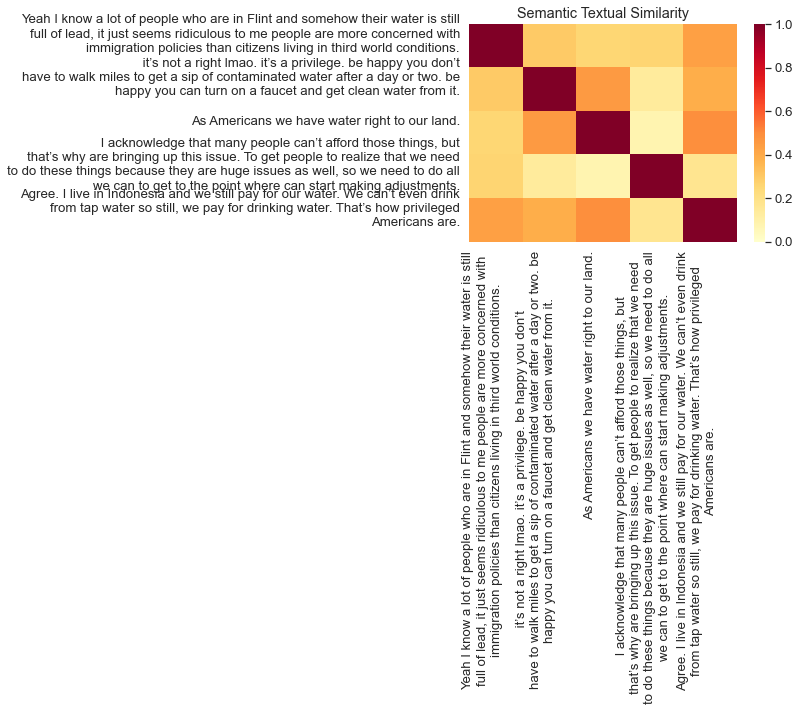

In [19]:
import seaborn as sns
def plot_similarity(labels, features, rotation):
    corr = np.inner(features, features)
    sns.set(font_scale=1.2)
    g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")

num_samples = 5
off_set = 500

plot_similarity(data.iloc[off_set:off_set+num_samples]['cleaned'], embeddings[off_set:off_set+num_samples], 90)

# Show neighbours of a comment

Define which comment to analyze



In [21]:
comment_index = 1324
comment = data["cleaned"][comment_index]
comment_list = data["cleaned"].tolist()
print(comment)

Deniers are so petty and small minded..




Print similar comments.

In [22]:
def get_top_similar(sentence, sentence_list, similarity_matrix, topN):
    # find the index of sentence in list
    index = sentence_list.index(sentence)
    # get the corresponding row in similarity matrix
    similarity_row = np.array(similarity_matrix[index, :])
    # get the indices of top similar
    indices = similarity_row.argsort()[-topN:][::-1]
    return [sentence_list[i] for i in indices]


for i, value in enumerate(get_top_similar(comment, comment_list, cosine_similarity_matrix, 20)):
    print("Top similar comment {}: {}".format(i+1, value))

Top similar comment 1: Deniers are so petty and small minded..


Top similar comment 2: climate change deniers are just cowards.


Top similar comment 3: Of course the deniers are boomers


Top similar comment 4: the skeptics are so selfish and self centred, all they think about is them.
theyre also victims of short termism.  
the activists are aware of the bigger picture and the need for us to change.


Top similar comment 5: so basically climate change skeptics are xenophobes


Top similar comment 6: I love how the skeptics don’t have to care about climate change because by the
time it takes over, they’ll be gone!


Top similar comment 7: Every one says the climate change skeptics are not scientist but your not
either so don’t be hypocritical


Top similar comment 8: the skeptics sounded pretty uneducated in this one.


Top similar comment 9: When are people going to realise that talking with climate deniers is a waste
of time?


Top similar comment 10: climate skeptics are the most 